# Imports

In [1]:
import numpy as np
import sys
import pickle
import os
import pandas as pd
import numpy as np
import numpy.ma as ma
from scipy.stats import norm
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture

## Helper Functions

In [2]:
%store -r analysis_hf
sys.path.insert(0, analysis_hf)
import covariance as c
import visualization as viz

# Set Directory Paths

In [65]:
# Directory path to load formatted Thickness At Path Data
%store -r thickAtPath_dataDir
# Directory path to save Calcualted Analysis Data
%store -r thickAtPath_CalData
# Directory path to save Figures
%store -r thickAtPath_Fig

%store -r path_CalData
%store -r path_dataDir

# Loading

## Volume Values at Pathology Regions

### Loading Pathology %AO

In [66]:
# path_TAU
with open(os.path.join(path_dataDir, 'path_TAU.pkl'), 'rb') as f:
    path_TAU = pickle.load(f)
f.close()

# path_TDP
with open(os.path.join(path_dataDir, 'path_TDP.pkl'), 'rb') as f:
    path_TDP = pickle.load(f)
f.close()

### Loading Volume Values at Pathology Regions - W Score

In [67]:
# HCVolumeAtPath_w
with open(os.path.join(thickAtPath_CalData, 'HCVolumeAtPath_w.pkl'), 'rb') as f:
    HCVolumeAtPath_w = pickle.load(f)
f.close()

# TAUVolumeAtPath_w
with open(os.path.join(thickAtPath_CalData, 'TAUVolumeAtPath_w.pkl'), 'rb') as f:
    TAUVolumeAtPath_w = pickle.load(f)
f.close()

# TDPVolumeAtPath_w
with open(os.path.join(thickAtPath_CalData, 'TDPVolumeAtPath_w.pkl'), 'rb') as f:
    TDPVolumeAtPath_w = pickle.load(f)
f.close()

## Missing Index (=few observations) from Pathology Dataset

### TAU 

In [68]:
# TAU_missing_index
with open(os.path.join(path_CalData, 'TAU_missing_index.pkl'), 'rb') as f:
    TAU_missing_index = pickle.load(f)
f.close()

### TDP

In [6]:
# TDP_missing_index
with open(os.path.join(path_CalData, 'TDP_missing_index.pkl'), 'rb') as f:
    TDP_missing_index = pickle.load(f)
f.close()

# Parameter/Variable Setting

## P-value Threshold List

In [7]:
# pthresh_list = [0.05]
pthresh = 0.05

## Covariance Matrix Threshold (to remove noise)

In [8]:
cov_thresh = 0.1

## Helper Function

### Calculating Cov Mat / Remove cov_threshold for now

In [9]:
def calcovCal(x, y, cov_thresh, type=None):
    """ Function that calculates Covariance Matrix between x and y
    
    Args:
        x (ndarray): 1st dataset
        y (ndarray): 2nd dataset
        cov_thresh (float): covariance matrix threshold (just to make suere there is no noise)
    
    Returns:
        covMat (ndarray) cov mat we calculated for x and y
    """
    
    # Sanity Check - Type Check
    assert(isinstance(x,np.ndarray))
    assert(isinstance(y,np.ndarray))
    
    # Sanity Check - if dataset have same number of regions (columns)
    assert(x.shape[1] == y.shape[1])
    
    # Define N (Number of regions, columns)
    N = x.shape[1]
    
    # Define Empty Cov Mat
    covMat = np.full((N,N), np.nan)
    
    for i in range(N):
        for j in range(N):
            if i!=j:
                # Sum of different regions for x and y both not NaN
                n = np.sum(~np.isnan(x[:,i]) & ~np.isnan(y[:,j]))
                
                if n > 3:
                    covMat[i, j] = ma.corrcoef(ma.masked_invalid(x[:,i]), ma.masked_invalid(y[:,j]))[0, 1]
                    if covMat[i, j] < cov_thresh:
                        covMat[i, j] = np.nan

    # Drop regions (Pathology) with less than 3 observations
    if type == 'Tau':
        covMat = np.delete(covMat, TAU_missing_index, axis = 0)
        covMat = np.delete(covMat, TAU_missing_index, axis = 1)
    elif type == 'TDP':
        covMat = np.delete(covMat, TDP_missing_index, axis = 0)
        covMat = np.delete(covMat, TDP_missing_index, axis = 1)
    else:
        raise Exception("No type defined")
    
    return covMat

## Covariance matrix visualization

In [10]:
def cov_viz(covMat, title, vmin=None, vmax=None):
    # Create a heatmap
    plt.imshow(covMat, cmap='Reds', vmin=vmin, vmax=vmax)

    # Add colorbar
    plt.colorbar()

    # Set labels and title
    plt.xlabel('Pathology Regions')
    plt.ylabel('Pathology Regions')
    plt.title(title)

    # Show the plot
    plt.show()

# Bagging on TAU & TDP [Pathology]

## TAU

### Covariance for TAU (Whole)

In [69]:
covTAU_Path = calcovCal(path_TAU, path_TAU, cov_thresh, type='Tau')

In [70]:
covTAU_Path.shape

(32, 32)

### Covariance for TAU (Bagging)

In [71]:
%%time

bagged_covTAU_Path = []

for row in range(TAUVolumeAtPath_w.shape[0]):
    # Get the TAU W Score Bag
    tau_bag = np.delete(path_TAU, row, axis=0)
    
    # Calculate the Covariance matrix for bagged TAU W score
    covMatTAU_bag = calcovCal(tau_bag, tau_bag, cov_thresh, type='Tau')
    
    # Add the calculated Cov Mat TAU 
    bagged_covTAU_Path.append(covMatTAU_bag)

bagged_covTAU_Path = np.array(bagged_covTAU_Path)

CPU times: user 5.19 s, sys: 6.21 ms, total: 5.2 s
Wall time: 5.21 s


### Calculate Mean and Std of Bagging

In [72]:
# Calculate the mean and standard deviation along the specified axis = 0 / along # of subjects
bagged_covTAU_Path_mean = np.nanmean(bagged_covTAU_Path, axis=0)
bagged_covTAU_Path_std = np.nanstd(bagged_covTAU_Path, axis=0, ddof=1)  # Set ddof to 1 for sample standard deviation

/var/folders/bv/64cmrb914297r9y0l4kmb4n80000gn/T/ipykernel_92339/4234459244.py:2: RuntimeWarning: Mean of empty slice
  bagged_covTAU_Path_mean = np.nanmean(bagged_covTAU_Path, axis=0)
/Users/hyroh/anaconda3/envs/Network_Analysis/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


#### Cov TAU (Whole)

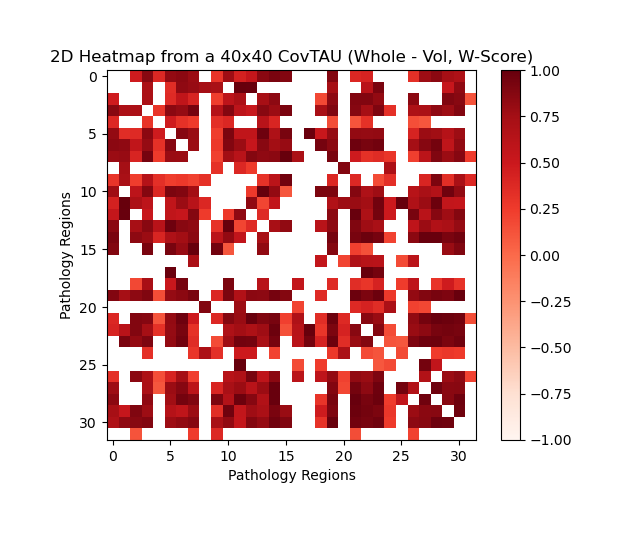

In [73]:
cov_viz(covTAU_Path, '2D Heatmap from a 40x40 CovTAU (Whole - Vol, W-Score)', vmin=-1, vmax=1)

#### Cov TAU (Bagging) [Mean]

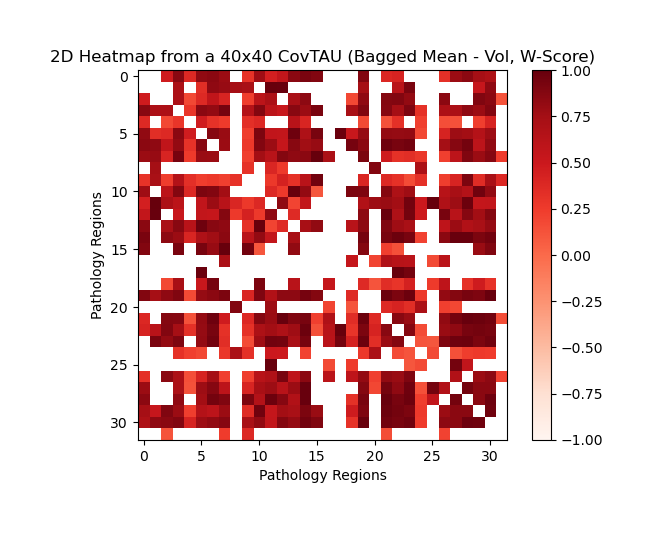

In [74]:
cov_viz(bagged_covTAU_Path_mean, '2D Heatmap from a 40x40 CovTAU (Bagged Mean - Vol, W-Score)', vmin=-1, vmax=1)

#### Cov TAU (Bagging) [Std]

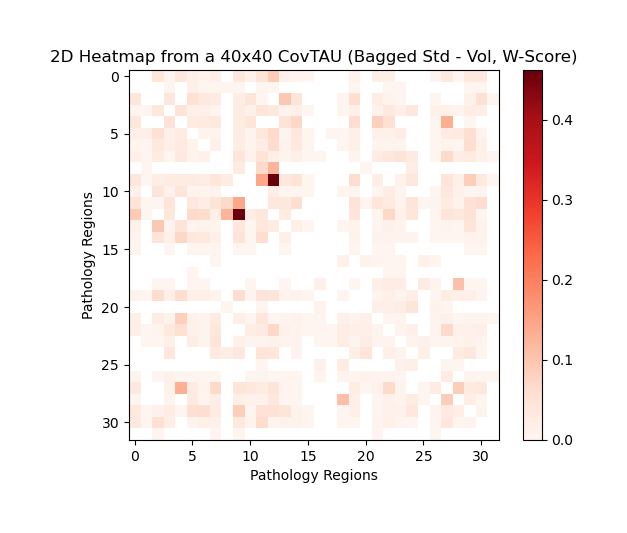

In [75]:
cov_viz(bagged_covTAU_Path_std, '2D Heatmap from a 40x40 CovTAU (Bagged Std - Vol, W-Score)')

## TDP

### Covariance for TDP (Whole)

In [76]:
covTDP_Path = calcovCal(path_TDP, path_TDP, cov_thresh, type='TDP')

In [77]:
covTDP_Path.shape

(32, 32)

### Covariance for TDP (Bagging)

In [78]:
%%time
bagged_covTDP_Path = []

for row in range(TDPVolumeAtPath_w.shape[0]):
    # Get the TAU W Score Bag
    tdp_bag = np.delete(path_TDP, row, axis=0)
    
    # Calculate the Covariance matrix for bagged TAU W score
    covMatTDP_bag = calcovCal(tdp_bag, tdp_bag, cov_thresh, type='TDP')
    
    # Add the calculated Cov Mat TAU 
    bagged_covTDP_Path.append(covMatTDP_bag)

bagged_covTDP_Path = np.array(bagged_covTDP_Path)

CPU times: user 7.69 s, sys: 6.04 ms, total: 7.7 s
Wall time: 7.72 s


### Calculate Mean and Std of Bagging

In [79]:
# Calculate the mean and standard deviation along the specified axis = 0 / along # of subjects
bagged_covTDP_Path_mean = np.nanmean(bagged_covTDP_Path, axis=0)
bagged_covTDP_Path_std = np.nanstd(bagged_covTDP_Path, axis=0, ddof=1)  # Set ddof to 1 for sample standard deviation

/var/folders/bv/64cmrb914297r9y0l4kmb4n80000gn/T/ipykernel_92339/3362858363.py:2: RuntimeWarning: Mean of empty slice
  bagged_covTDP_Path_mean = np.nanmean(bagged_covTDP_Path, axis=0)
/Users/hyroh/anaconda3/envs/Network_Analysis/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


#### Cov TDP (Whole)

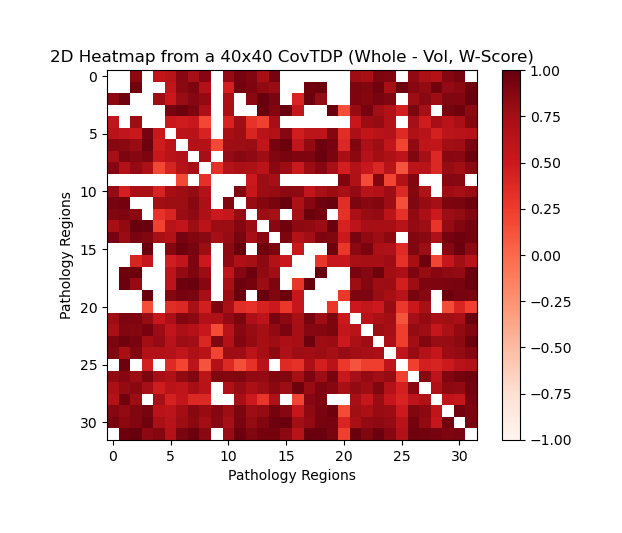

In [80]:
cov_viz(covTDP_Path, '2D Heatmap from a 40x40 CovTDP (Whole - Vol, W-Score)', vmin=-1, vmax=1)

#### Cov TDP (Bagging) [Mean]

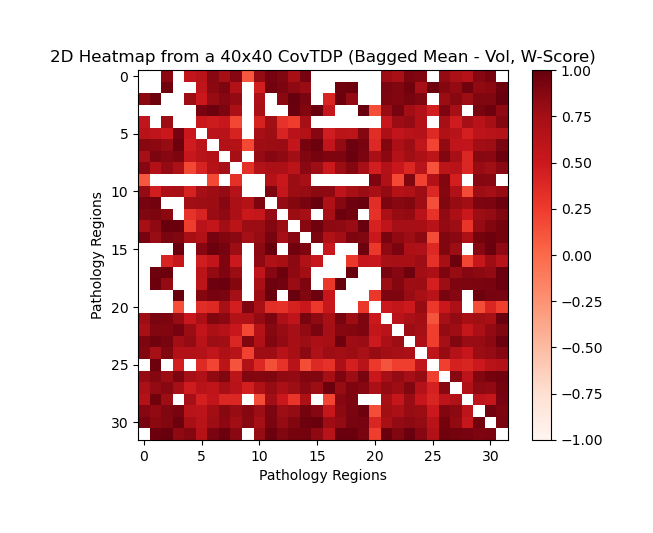

In [81]:
cov_viz(bagged_covTDP_Path_mean, '2D Heatmap from a 40x40 CovTDP (Bagged Mean - Vol, W-Score)', vmin=-1, vmax=1)

#### Cov TDP (Bagging) [Std]

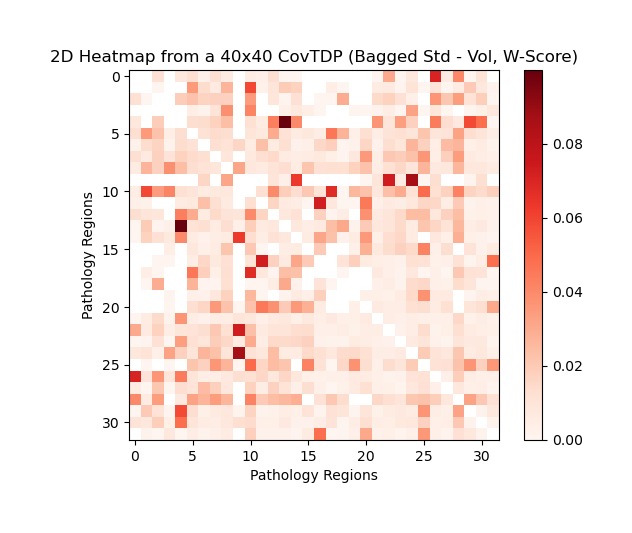

In [82]:
cov_viz(bagged_covTDP_Path_std, '2D Heatmap from a 40x40 CovTDP (Bagged Std - Vol, W-Score)')

# Fit GMM for bagging distribution

## TAU

In [83]:
bagged_covTAU_Path.shape

(26, 32, 32)

In [88]:
# Get 26 distribution of CovMat region [0, 1]
curr_data = bagged_covTAU_Path[:, 0, 2]

In [89]:
curr_data

array([0.46642886, 0.47644806, 0.48078194, 0.47644806, 0.47644806,
       0.44262609, 0.47644806, 0.47644806, 0.47644806, 0.47644806,
       0.47644806, 0.47644806, 0.47644806, 0.47644806, 0.47644806,
       0.3239093 , 0.47644806, 0.47644806, 0.60886038, 0.47644806,
       0.50686761, 0.47644806, 0.47644806, 0.47644806, 0.47644806,
       0.47644806])

/var/folders/bv/64cmrb914297r9y0l4kmb4n80000gn/T/ipykernel_92339/2403244001.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(curr_data, hist=True, kde=True, rug=True,


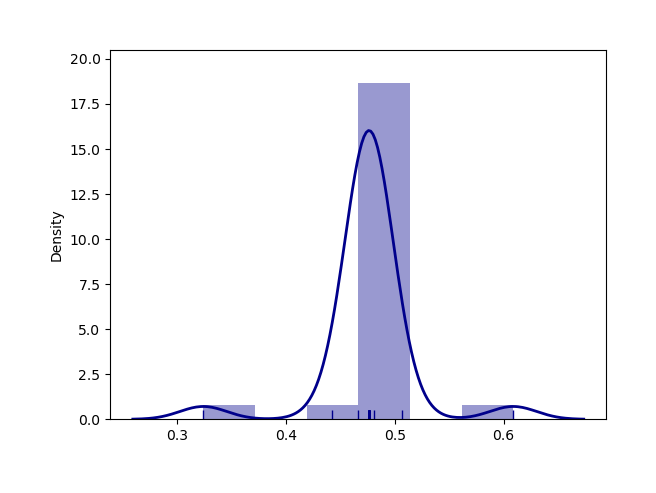

In [90]:
# Fitting a distribution on this distribution 
ax = sns.distplot(curr_data, hist=True, kde=True, rug=True,
             bins='auto', color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

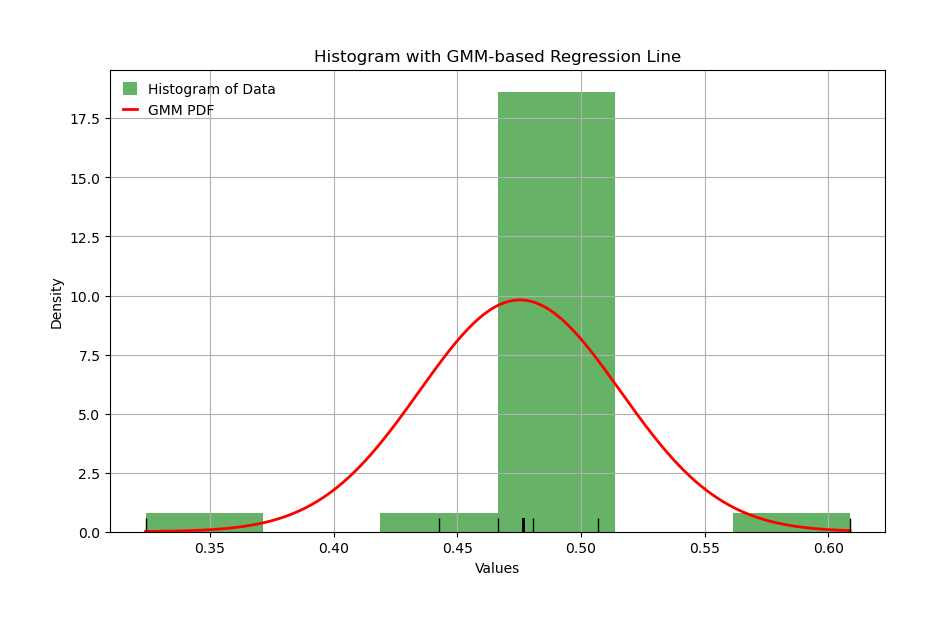

In [91]:
# 1d array across 26 bagging distribution + Remove NaN values
data = curr_data[~np.isnan(curr_data)]

# Plot the histogram of the data
plt.figure(figsize=(10, 6))
count, bins, ignored = plt.hist(data, bins='auto', density=True, alpha=0.6, color='g', label='Histogram of Data')

# Fit a GMM to the data
gmm = GaussianMixture(n_components=1, random_state=42)  # You can adjust the number of components
gmm.fit(data.reshape(-1, 1))

# Generate a dense set of points for plotting the PDF
x = np.linspace(min(data), max(data), 1000).reshape(-1, 1)
logprob = gmm.score_samples(x)
pdf = np.exp(logprob)

# Plot the PDF as the regression line
plt.plot(x, pdf, '-r', linewidth=2, label='GMM PDF')

# Add grid to the plot
plt.grid(True)

# Create a rug plot at the bottom of the x-axis for each data point
ymin, ymax = plt.ylim()  # Get the current y-axis limits
rug_y = ymin * 0.95  # Position for the rug ticks, slightly below the bottom of the plot
plt.plot(data, [rug_y]*len(data), '|', color='black', markersize=20)

# figure title and x,y labels
plt.title('Histogram with GMM-based Regression Line')
plt.xlabel('Values')
plt.ylabel('Density')

plt.legend()
plt.show()


In [183]:
bagged_covMat = bagged_covTAU_Path

# List to save GMM models (TAU)
gmm_list_Tau_Path = []
lessthan2_index_Tau_Path = []
morethanequal2_index_Tau_Path = []

for i in range(bagged_covMat.shape[1]):
    for j in range(bagged_covMat.shape[2]):
        if i > j: # get the lower triangle
            # Get the curr data
            curr_data = bagged_covMat[:, i, j]
            
            # 1d array across 26 bagging distribution + Remove NaN values
            data = curr_data[~np.isnan(curr_data)]

            # check if all the currData is NaN, so data is empty
            if data.size < 2 :
                lessthan2_index_Tau_Path.append((i, j))
            else:
                morethanequal2_index_Tau_Path.append((i, j))

                # Fit a GMM to the data
                gmm = GaussianMixture(n_components=1, random_state=42)  
                gmm.fit(data.reshape(-1, 1))

                # Save the GMM model to the list
                gmm_list_Tau_Path.append(gmm)

In [93]:
len(morethanequal2_index_Tau_Path)

301

In [94]:
len(lessthan2_index_Tau_Path)

195

## TDP

In [95]:
bagged_covMat = bagged_covTDP_Path

# List to save GMM models (TDP)
gmm_list_TDP_Path = []
lessthan2_index_TDP_Path = []
morethanequal2_index_TDP_Path = []

for i in range(bagged_covMat.shape[1]):
    for j in range(bagged_covMat.shape[2]):
        if i > j: # get the lower triangle
            # Get the curr data
            curr_data = bagged_covMat[:, i, j]
            
            # 1d array across 26 bagging distribution + Remove NaN values
            data = curr_data[~np.isnan(curr_data)]

            # check if all the currData is NaN, so data is empty
            if data.size < 2 :
                lessthan2_index_TDP_Path.append((i, j))
            else:
                morethanequal2_index_TDP_Path.append((i, j))
                
                # Fit a GMM to the data
                gmm = GaussianMixture(n_components=1, random_state=42)  
                gmm.fit(data.reshape(-1, 1))

                # Save the GMM model to the list
                gmm_list_TDP_Path.append(gmm)

In [96]:
len(morethanequal2_index_TDP_Path)

431

In [97]:
len(lessthan2_index_TDP_Path)

65

# Bagging on TAU & TDP [MR Volume W-Score]

## TAU

### Covariance for TAU (Whole)

In [11]:
covTAU_VolW = calcovCal(TAUVolumeAtPath_w, TAUVolumeAtPath_w, cov_thresh, type='Tau')

In [12]:
covTAU_VolW.shape

(32, 32)

### Covariance for TAU (Bagging)

In [13]:
%%time

bagged_covTAU_VolW = []

for row in range(TAUVolumeAtPath_w.shape[0]):
    # Get the TAU W Score Bag
    tauW_bag = np.delete(TAUVolumeAtPath_w, row, axis=0)
    
    # Calculate the Covariance matrix for bagged TAU W score
    covMatTAU_bag = calcovCal(tauW_bag, tauW_bag, cov_thresh, type='Tau')
    
    # Add the calculated Cov Mat TAU 
    bagged_covTAU_VolW.append(covMatTAU_bag)

bagged_covTAU_VolW = np.array(bagged_covTAU_VolW)

CPU times: user 5.52 s, sys: 13.5 ms, total: 5.53 s
Wall time: 5.54 s


### Calculate Mean and Std of Bagging

In [14]:
# Calculate the mean and standard deviation along the specified axis = 0 / along # of subjects
bagged_covTAU_VolW_mean = np.nanmean(bagged_covTAU_VolW, axis=0)
bagged_covTAU_VolW_std = np.nanstd(bagged_covTAU_VolW, axis=0, ddof=1)  # Set ddof to 1 for sample standard deviation

/var/folders/bv/64cmrb914297r9y0l4kmb4n80000gn/T/ipykernel_92339/1607040298.py:2: RuntimeWarning: Mean of empty slice
  bagged_covTAU_VolW_mean = np.nanmean(bagged_covTAU_VolW, axis=0)
/Users/hyroh/anaconda3/envs/Network_Analysis/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


#### Cov TAU (Whole)

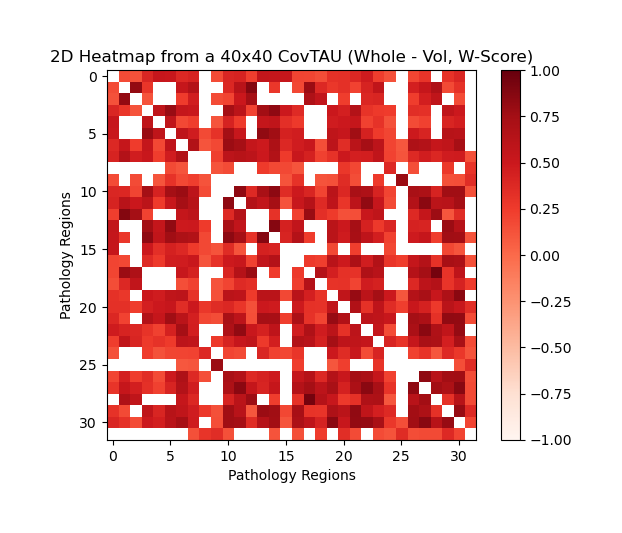

In [15]:
cov_viz(covTAU_VolW, '2D Heatmap from a 40x40 CovTAU (Whole - Vol, W-Score)', vmin=-1, vmax=1)

#### Cov TAU (Bagging) [Mean]

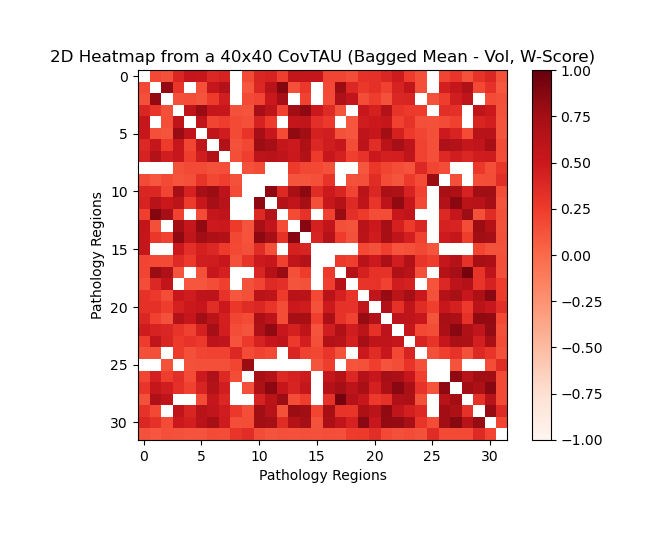

In [16]:
cov_viz(bagged_covTAU_VolW_mean, '2D Heatmap from a 40x40 CovTAU (Bagged Mean - Vol, W-Score)', vmin=-1, vmax=1)

#### Cov TAU (Bagging) [Std]

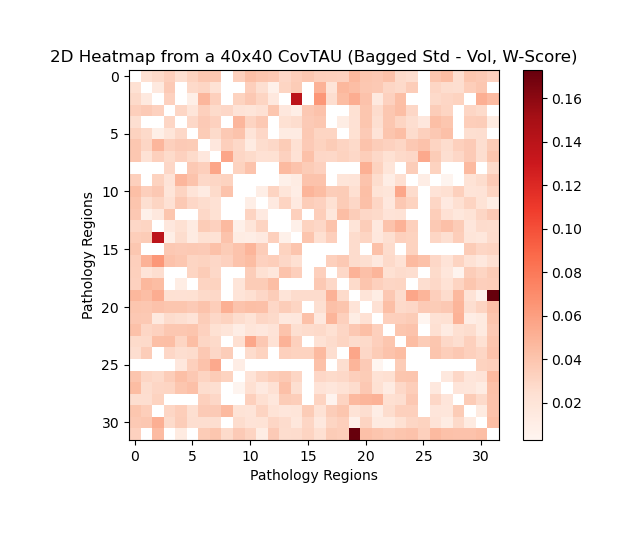

In [17]:
cov_viz(bagged_covTAU_VolW_std, '2D Heatmap from a 40x40 CovTAU (Bagged Std - Vol, W-Score)')

## TDP

### Covariance for TDP (Whole)

In [18]:
covTDP_VolW = calcovCal(TDPVolumeAtPath_w, TDPVolumeAtPath_w, cov_thresh, type='TDP')

In [19]:
covTDP_VolW.shape

(32, 32)

### Covariance for TDP (Bagging)

In [20]:
%%time
bagged_covTDP_VolW = []

for row in range(TDPVolumeAtPath_w.shape[0]):
    # Get the TAU W Score Bag
    tdpW_bag = np.delete(TDPVolumeAtPath_w, row, axis=0)
    
    # Calculate the Covariance matrix for bagged TAU W score
    covMatTDP_bag = calcovCal(tdpW_bag, tdpW_bag, cov_thresh, type='TDP')
    
    # Add the calculated Cov Mat TAU 
    bagged_covTDP_VolW.append(covMatTDP_bag)

bagged_covTDP_VolW = np.array(bagged_covTDP_VolW)

CPU times: user 6.41 s, sys: 8.88 ms, total: 6.42 s
Wall time: 6.43 s


### Calculate Mean and Std of Bagging

In [21]:
# Calculate the mean and standard deviation along the specified axis = 0 / along # of subjects
bagged_covTDP_VolW_mean = np.nanmean(bagged_covTDP_VolW, axis=0)
bagged_covTDP_VolW_std = np.nanstd(bagged_covTDP_VolW, axis=0, ddof=1)  # Set ddof to 1 for sample standard deviation

/var/folders/bv/64cmrb914297r9y0l4kmb4n80000gn/T/ipykernel_92339/2801597895.py:2: RuntimeWarning: Mean of empty slice
  bagged_covTDP_VolW_mean = np.nanmean(bagged_covTDP_VolW, axis=0)


#### Cov TDP (Whole)

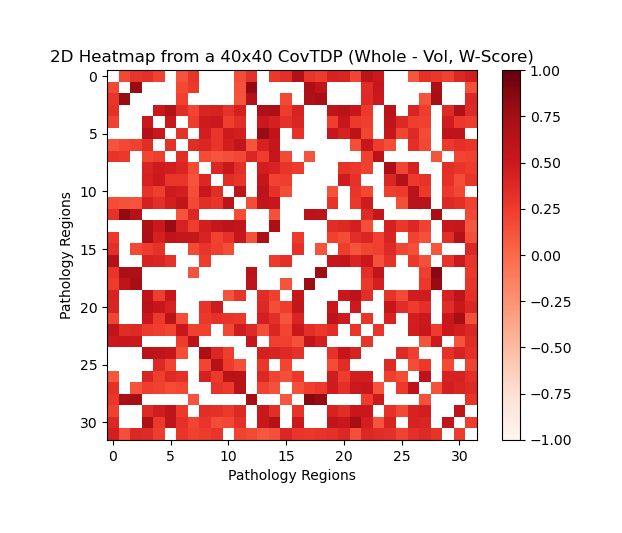

In [22]:
cov_viz(covTDP_VolW, '2D Heatmap from a 40x40 CovTDP (Whole - Vol, W-Score)', vmin=-1, vmax=1)

#### Cov TDP (Bagging) [Mean]

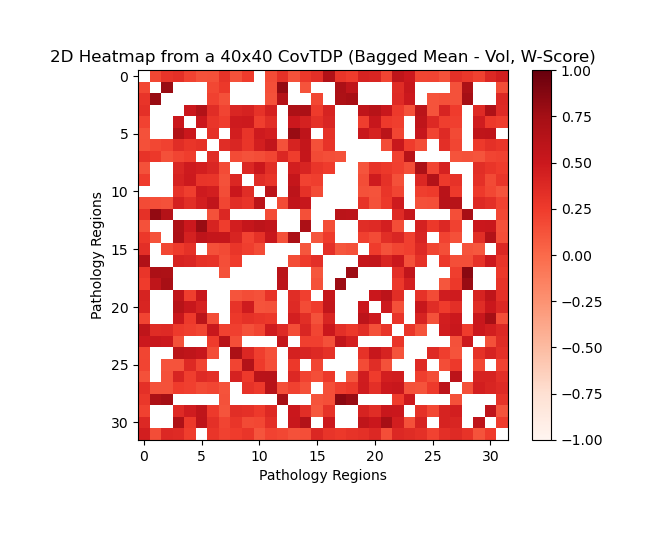

In [23]:
cov_viz(bagged_covTDP_VolW_mean, '2D Heatmap from a 40x40 CovTDP (Bagged Mean - Vol, W-Score)', vmin=-1, vmax=1)

#### Cov TDP (Bagging) [Std]

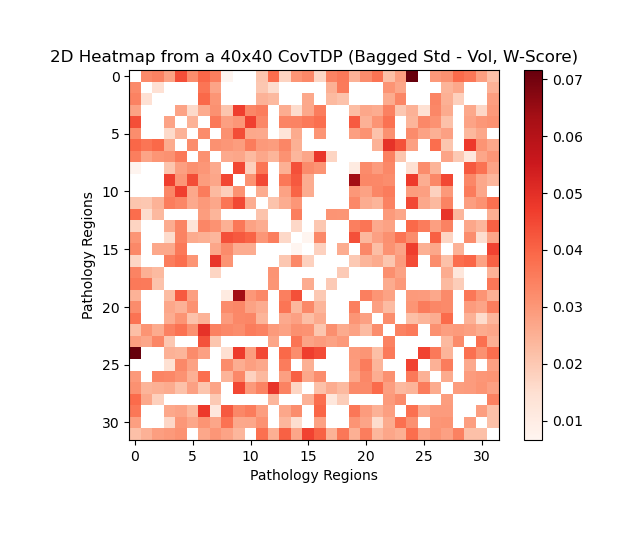

In [24]:
cov_viz(bagged_covTDP_VolW_std, '2D Heatmap from a 40x40 CovTDP (Bagged Std - Vol, W-Score)')

# Fit GMM for bagging distribution

## TAU

In [25]:
bagged_covTAU_VolW.shape

(26, 32, 32)

In [27]:
# Get 26 distribution of CovMat region [0, 1]
curr_data = bagged_covTAU_VolW[:, 0, 1]

/var/folders/bv/64cmrb914297r9y0l4kmb4n80000gn/T/ipykernel_92339/2403244001.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(curr_data, hist=True, kde=True, rug=True,


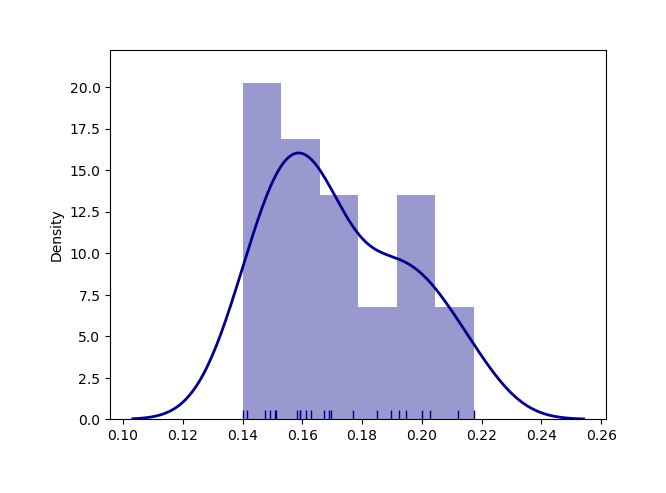

In [28]:
# Fitting a distribution on this distribution 
ax = sns.distplot(curr_data, hist=True, kde=True, rug=True,
             bins='auto', color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

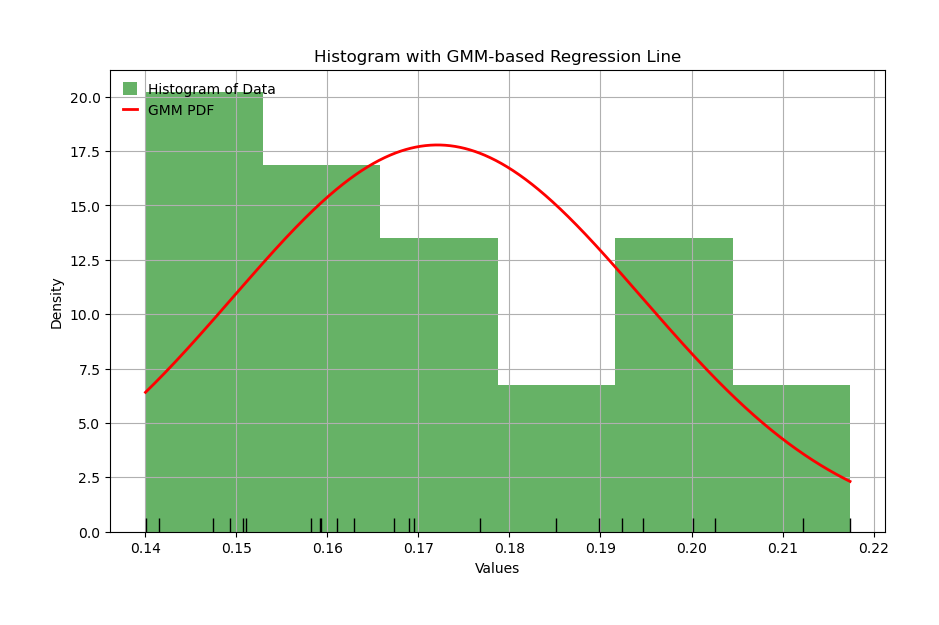

In [29]:
# 1d array across 26 bagging distribution + Remove NaN values
data = curr_data[~np.isnan(curr_data)]

# Plot the histogram of the data
plt.figure(figsize=(10, 6))
count, bins, ignored = plt.hist(data, bins='auto', density=True, alpha=0.6, color='g', label='Histogram of Data')

# Fit a GMM to the data
gmm = GaussianMixture(n_components=1, random_state=42)  # You can adjust the number of components
gmm.fit(data.reshape(-1, 1))

# Generate a dense set of points for plotting the PDF
x = np.linspace(min(data), max(data), 1000).reshape(-1, 1)
logprob = gmm.score_samples(x)
pdf = np.exp(logprob)

# Plot the PDF as the regression line
plt.plot(x, pdf, '-r', linewidth=2, label='GMM PDF')

# Add grid to the plot
plt.grid(True)

# Create a rug plot at the bottom of the x-axis for each data point
ymin, ymax = plt.ylim()  # Get the current y-axis limits
rug_y = ymin * 0.95  # Position for the rug ticks, slightly below the bottom of the plot
plt.plot(data, [rug_y]*len(data), '|', color='black', markersize=20)

# figure title and x,y labels
plt.title('Histogram with GMM-based Regression Line')
plt.xlabel('Values')
plt.ylabel('Density')

plt.legend()
plt.show()


In [98]:
bagged_covMat = bagged_covTAU_VolW

# List to save GMM models (TAU)
gmm_list_Tau_VolW = []
lessthan2_index_Tau_VolW = []
morethanequal2_index_Tau_VolW = []

for i in range(bagged_covMat.shape[1]):
    for j in range(bagged_covMat.shape[2]):
        if i > j: # get the lower triangle
            # Get the curr data
            curr_data = bagged_covMat[:, i, j]
            
            # 1d array across 26 bagging distribution + Remove NaN values
            data = curr_data[~np.isnan(curr_data)]

            # check if all the currData is NaN, so data is empty
            if data.size < 2 :
                lessthan2_index_Tau_VolW.append((i, j))
            else:
                morethanequal2_index_Tau_VolW.append((i, j))
                
                # Fit a GMM to the data
                gmm = GaussianMixture(n_components=1, random_state=42)  
                gmm.fit(data.reshape(-1, 1))

                # Save the GMM model to the list
                gmm_list_Tau_VolW.append(gmm)

In [99]:
len(morethanequal2_index_Tau_VolW)

424

In [100]:
len(lessthan2_index_Tau_VolW)

72

## TDP

In [101]:
bagged_covMat = bagged_covTDP_VolW

# List to save GMM models (TDP)
gmm_list_TDP_VolW = []
lessthan2_index_TDP_VolW = []
morethanequal2_index_TDP_VolW = []

for i in range(bagged_covMat.shape[1]):
    for j in range(bagged_covMat.shape[2]):
        if i > j: # get the lower triangle
            # Get the curr data
            curr_data = bagged_covMat[:, i, j]
            
            # 1d array across 26 bagging distribution + Remove NaN values
            data = curr_data[~np.isnan(curr_data)]

            # check if all the currData is NaN, so data is empty
            if data.size < 2 :
                lessthan2_index_TDP_VolW.append((i, j))
            else:
                morethanequal2_index_TDP_VolW.append((i, j))
                
                # Fit a GMM to the data
                gmm = GaussianMixture(n_components=1, random_state=42)  
                gmm.fit(data.reshape(-1, 1))

                # Save the GMM model to the list
                gmm_list_TDP_VolW.append(gmm)

In [102]:
len(morethanequal2_index_TDP_VolW)

340

In [103]:
len(lessthan2_index_TDP_VolW)

156

# Find the common GMM models to use for comparison

In [113]:
# common morethanequal2 index
# Convert lists to sets
set1 = set(morethanequal2_index_Tau_Path)
set2 = set(morethanequal2_index_TDP_Path)
set3 = set(morethanequal2_index_Tau_VolW)
set4 = set(morethanequal2_index_TDP_VolW)

# Find common elements
common_elements = set1.intersection(set2, set3, set4)

# Convert the result back to a list, if needed
common_elements_list = list(common_elements)

common_elements_list.sort()

In [114]:
len(common_elements_list)

196

In [121]:
# Tau_Path
Tau_Path_common_ind = []
index_type = morethanequal2_index_Tau_Path
for index, tuple in enumerate(index_type):
    if tuple in common_elements_list:
        Tau_Path_common_ind.append(index)

In [122]:
# TDP_Path
TDP_Path_common_ind = []
index_type = morethanequal2_index_TDP_Path
for index, tuple in enumerate(index_type):
    if tuple in common_elements_list:
        TDP_Path_common_ind.append(index)

In [123]:
# Tau_VolW
Tau_VolW_common_ind = []
index_type = morethanequal2_index_Tau_VolW
for index, tuple in enumerate(index_type):
    if tuple in common_elements_list:
        Tau_VolW_common_ind.append(index)

In [124]:
# TDP_VolW
TDP_VolW_common_ind = []
index_type = morethanequal2_index_TDP_VolW
for index, tuple in enumerate(index_type):
    if tuple in common_elements_list:
        TDP_VolW_common_ind.append(index)

In [125]:
print(len(Tau_Path_common_ind))
print(len(TDP_Path_common_ind))
print(len(Tau_VolW_common_ind))
print(len(TDP_VolW_common_ind))

196
196
196
196


In [128]:
gmm_list_Tau_Path_Final = [gmm_list_Tau_Path[i] for i in Tau_Path_common_ind]
gmm_list_TDP_Path_Final = [gmm_list_TDP_Path[i] for i in TDP_Path_common_ind]
gmm_list_Tau_VolW_Final = [gmm_list_Tau_VolW[i] for i in Tau_VolW_common_ind]
gmm_list_TDP_VolW_Final = [gmm_list_TDP_VolW[i] for i in TDP_VolW_common_ind]

In [130]:
print(len(gmm_list_Tau_Path_Final))
print(len(gmm_list_TDP_Path_Final))
print(len(gmm_list_Tau_VolW_Final))
print(len(gmm_list_TDP_VolW_Final))

196
196
196
196


# KL Divergence as a metric
![Screenshot 2024-02-06 at 4.10.58 AM.png](<attachment:Screenshot 2024-02-06 at 4.10.58 AM.png>)
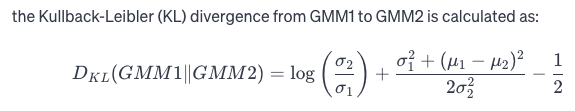

In [205]:
def kl_div(gmm1, gmm2):
    # Aget mean and std of gmm1 and gmm2
    mu1 = gmm1.means_.flatten()[0]
    sigma1 = np.sqrt(gmm1.covariances_.flatten()[0])

    mu2 = gmm2.means_.flatten()[0]
    sigma2 = np.sqrt(gmm2.covariances_.flatten()[0])

    # Calculate KL divergence
    kl_div = np.log(sigma2 / sigma1) + (sigma1**2 + (mu1 - mu2)**2) / (2 * sigma2**2) - 0.5

    return kl_div


def list_comp(gmm_list1, gmm_list2):
    kldiv_sum = 0

    for i in range(len(gmm_list1)):
        # get gmm1 and gmm2
        gmm1 = gmm_list1[i]
        gmm2 = gmm_list2[i]

        curr_kldiv = kl_div(gmm1, gmm2)
        kldiv_sum += curr_kldiv
    
    return kldiv_sum

# Distribution comparison

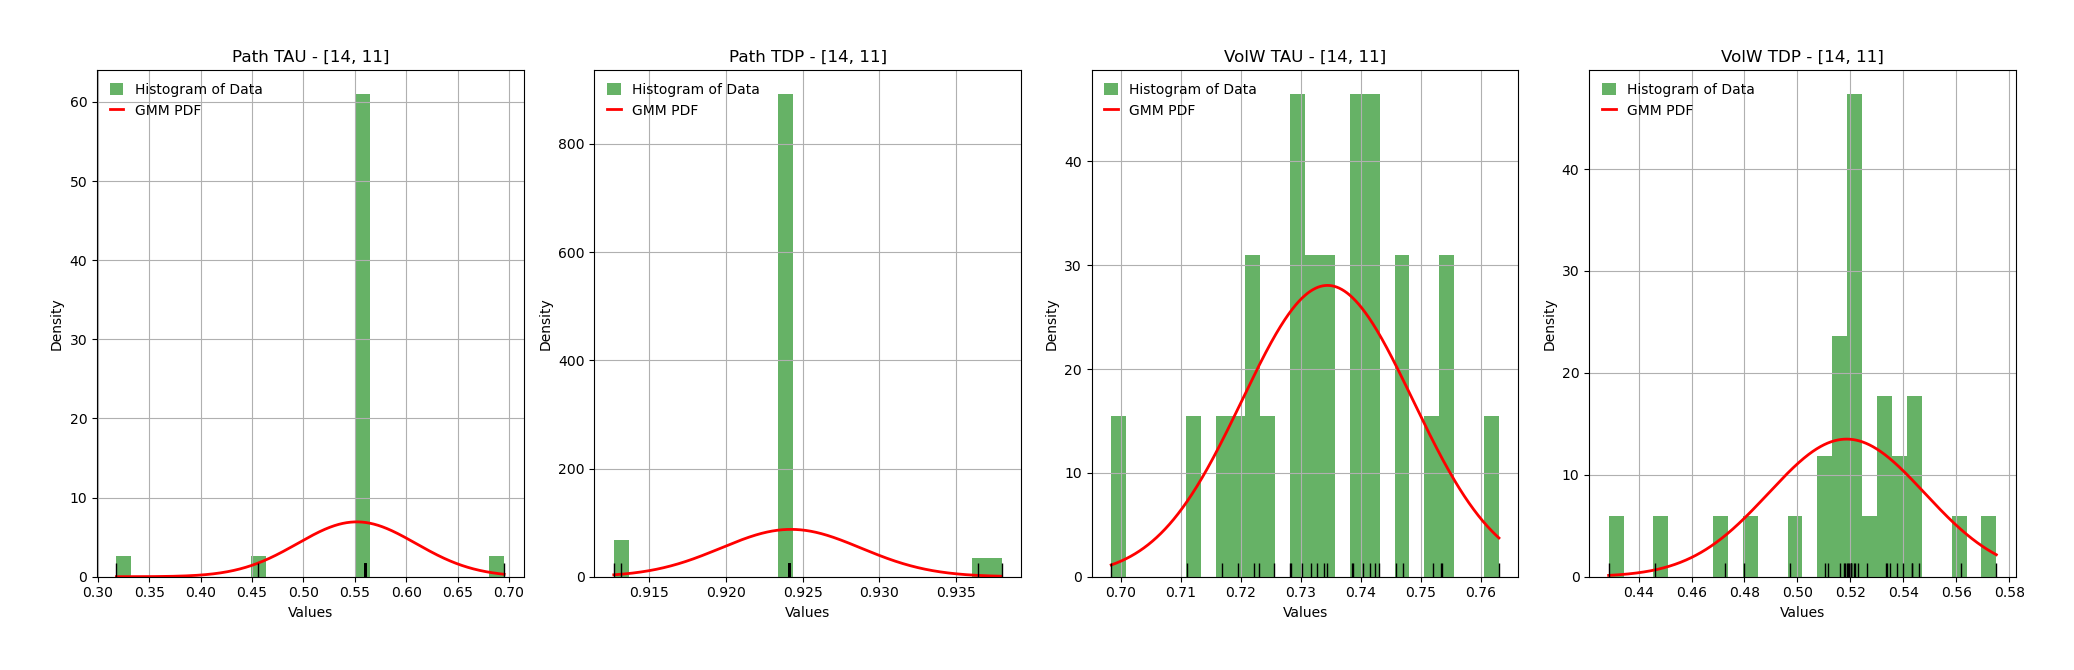

[Path] TAU vs [Path] TDP KLD: 3413.4710817705836
**[Path] TAU vs [VolW] TAU KLD: 88.74373051374862
[Path] TAU vs [VolW] TDP KLD: 1.3660401135289142
[Path] TDP vs [VolW] TAU KLD: 89.77264442852271
**[Path] TDP vs [VolW] TDP KLD: 95.63819284955282
[VolW] TAU vs [VolW] TDP KLD: 27.040983656821858


In [193]:
bagged_data_sets = [bagged_covTAU_Path, bagged_covTDP_Path, bagged_covTAU_VolW, bagged_covTDP_VolW]

plt.figure(figsize=(20, 6))


ele = 50
row = common_elements_list[ele][0]
col = common_elements_list[ele][1]

gmm_list = []
for i, bagged_data in enumerate(bagged_data_sets, start=1):

    curr_data = bagged_data[:, row, col]
    # 1d array across 26 bagging distribution + Remove NaN values
    data = curr_data[~np.isnan(curr_data)]

    # Create subplot for each bagged_data set
    plt.subplot(1, 4, i)

    # Plot the histogram of the data
    count, bins, ignored = plt.hist(data, bins=26, density=True, alpha=0.6, color='g', label='Histogram of Data')

    # Fit a GMM to the data
    gmm = GaussianMixture(n_components=1, random_state=42)  # You can adjust the number of components
    gmm.fit(data.reshape(-1, 1))

    gmm_list.append(gmm)

    # Generate a dense set of points for plotting the PDF
    x = np.linspace(min(data), max(data), 1000).reshape(-1, 1)
    logprob = gmm.score_samples(x)
    pdf = np.exp(logprob)

    # Plot the PDF as the regression line
    plt.plot(x, pdf, '-r', linewidth=2, label='GMM PDF')

    # Add grid to the plot
    plt.grid(True)

    # Create a rug plot at the bottom of the x-axis for each data point
    ymin, ymax = plt.ylim()  # Get the current y-axis limits
    rug_y = ymin * 0.95  # Position for the rug ticks, slightly below the bottom of the plot
    plt.plot(data, [rug_y]*len(data), '|', color='black', markersize=20)

    # figure title and x,y labels
    if i == 1:
        plt.title(f'Path TAU - [{row}, {col}]')
    elif i == 2:
        plt.title(f'Path TDP - [{row}, {col}]') 
    elif i == 3:
        plt.title(f'VolW TAU - [{row}, {col}]')
    else:
        plt.title(f'VolW TDP - [{row}, {col}]')

    plt.xlabel('Values')
    plt.ylabel('Density')

    plt.legend()
    
plt.tight_layout()
plt.show()

print(f'[Path] TAU vs [Path] TDP KLD: {kl_div(gmm_list[0], gmm_list[1])}')
print(f'**[Path] TAU vs [VolW] TAU KLD: {kl_div(gmm_list[0], gmm_list[2])}')
print(f'[Path] TAU vs [VolW] TDP KLD: {kl_div(gmm_list[0], gmm_list[3])}')
print(f'[Path] TDP vs [VolW] TAU KLD: {kl_div(gmm_list[1], gmm_list[2])}')
print(f'**[Path] TDP vs [VolW] TDP KLD: {kl_div(gmm_list[1], gmm_list[3])}')
print(f'[VolW] TAU vs [VolW] TDP KLD: {kl_div(gmm_list[2], gmm_list[3])}')

In [207]:
n = len(common_elements_list)

gmm_Tau_Path = gmm_list_Tau_Path_Final
gmm_TDP_Path = gmm_list_TDP_Path_Final
gmm_Tau_VolW = gmm_list_Tau_VolW_Final
gmm_TDP_VolW = gmm_list_TDP_VolW_Final

# [Path] Tau vs [Path] TDP
gmm_list1 = gmm_Tau_Path
gmm_list2 = gmm_TDP_Path
kldiv_sum_1 = list_comp(gmm_list1, gmm_list2)

# [Path] TAU vs [VolW] TAU 
gmm_list1 = gmm_Tau_Path
gmm_list2 = gmm_Tau_VolW
kldiv_sum_2 = list_comp(gmm_list1, gmm_list2)

# [Path] TAU vs [VolW] TDP 
gmm_list1 = gmm_Tau_Path
gmm_list2 = gmm_TDP_VolW
kldiv_sum_3 = list_comp(gmm_list1, gmm_list2) 

# [Path] TDP vs [VolW] TAU 
gmm_list1 = gmm_TDP_Path
gmm_list2 = gmm_Tau_VolW
kldiv_sum_4 = list_comp(gmm_list1, gmm_list2)  

# [Path] TDP vs [VolW] TDP 
gmm_list1 = gmm_TDP_Path
gmm_list2 = gmm_TDP_VolW
kldiv_sum_5 = list_comp(gmm_list1, gmm_list2)

# [VolW] TAU vs [VolW] TDP 
gmm_list1 = gmm_Tau_VolW
gmm_list2 = gmm_TDP_VolW
kldiv_sum_6 = list_comp(gmm_list1, gmm_list2)


print(f'[Path] TAU vs [Path] TDP / KLD: {kldiv_sum_1/n: .2f}')
print(f'**[Path] TAU vs [VolW] TAU / KLD: {kldiv_sum_2/n: .2f}')
print(f'[Path] TAU vs [VolW] TDP / KLD: {kldiv_sum_3/n: .2f}')
print(f'[Path] TDP vs [VolW] TAU / KLD: {kldiv_sum_4/n: .2f}')
print(f'**[Path] TDP vs [VolW] TDP / KLD: {kldiv_sum_5/n: .2f}')
print(f'[VolW] TAU vs [VolW] TDP / KLD: {kldiv_sum_6/n: .2f}')

[Path] TAU vs [Path] TDP / KLD:  4317.55
**[Path] TAU vs [VolW] TAU / KLD:  54.59
[Path] TAU vs [VolW] TDP / KLD:  157.29
[Path] TDP vs [VolW] TAU / KLD:  97.76
**[Path] TDP vs [VolW] TDP / KLD:  172.77
[VolW] TAU vs [VolW] TDP / KLD:  52.66


# Normalize the range so that the PDF have same range

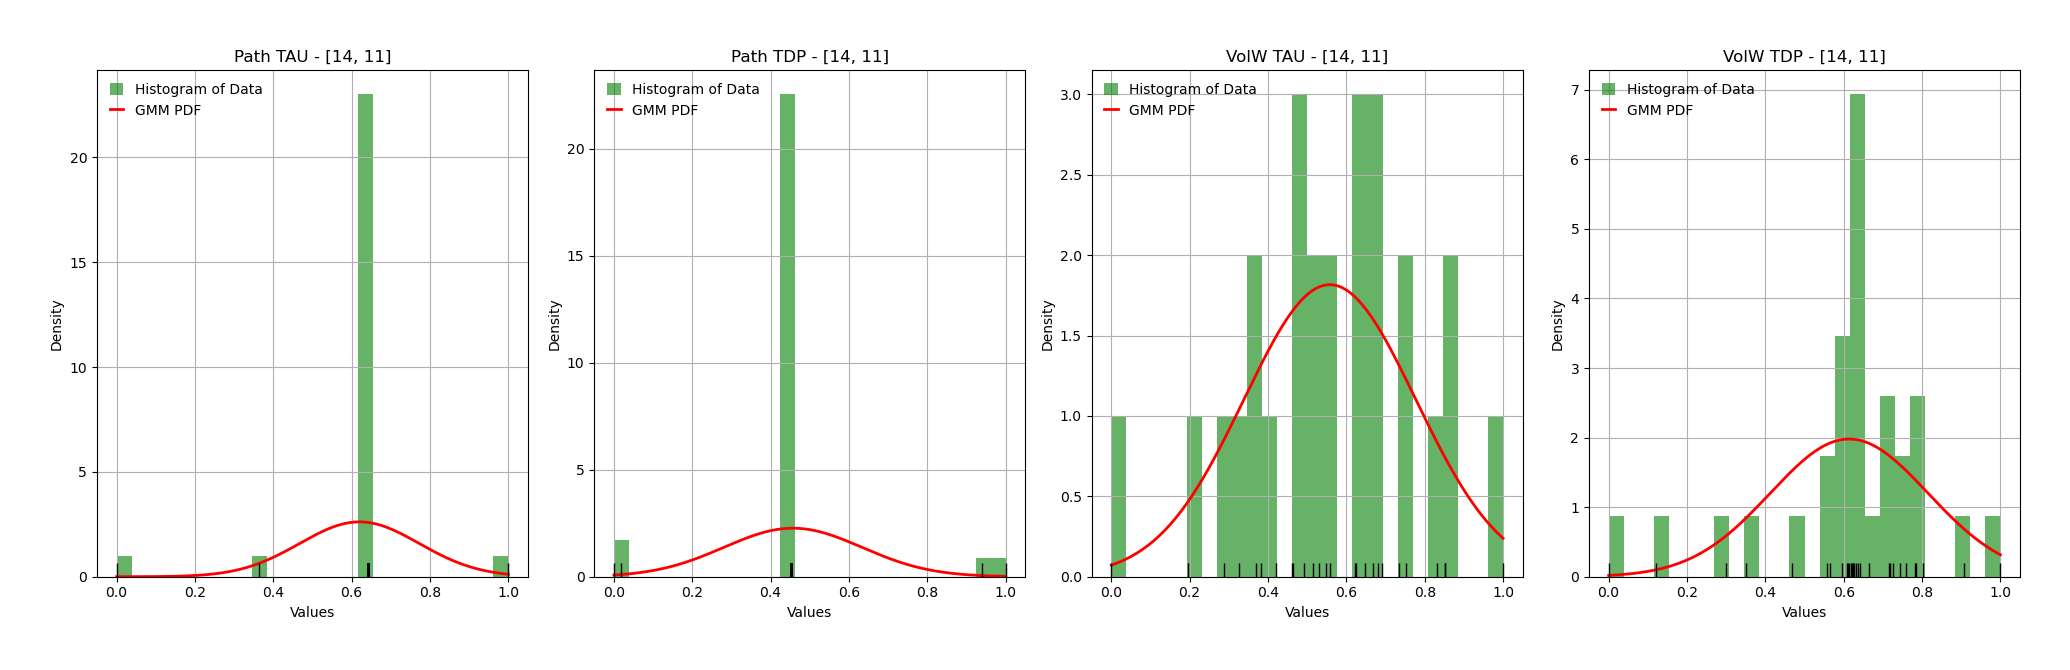

[Path] TAU vs [Path] TDP KLD: 0.4480460618806241
**[Path] TAU vs [VolW] TAU KLD: 0.14569167997969878
[Path] TAU vs [VolW] TDP KLD: 0.06555583244933527
[Path] TDP vs [VolW] TAU KLD: 0.1483988734363867
**[Path] TDP vs [VolW] TDP KLD: 0.32038440062400053
[VolW] TAU vs [VolW] TDP KLD: 0.046415347457188005


In [208]:
bagged_data_sets = [bagged_covTAU_Path, bagged_covTDP_Path, bagged_covTAU_VolW, bagged_covTDP_VolW]

plt.figure(figsize=(20, 6))


ele = 50
row = common_elements_list[ele][0]
col = common_elements_list[ele][1]

gmm_list = []
for i, bagged_data in enumerate(bagged_data_sets, start=1):

    curr_data = bagged_data[:, row, col]
    # 1d array across 26 bagging distribution + Remove NaN values
    data = curr_data[~np.isnan(curr_data)]

    ### NORMALIZING
    data = (data - data.min()) / (data.max() - data.min())

    # Create subplot for each bagged_data set
    plt.subplot(1, 4, i)

    # Plot the histogram of the data
    count, bins, ignored = plt.hist(data, bins=26, density=True, alpha=0.6, color='g', label='Histogram of Data')

    # Fit a GMM to the data
    gmm = GaussianMixture(n_components=1, random_state=42)  # You can adjust the number of components
    gmm.fit(data.reshape(-1, 1))

    gmm_list.append(gmm)

    # Generate a dense set of points for plotting the PDF
    x = np.linspace(min(data), max(data), 1000).reshape(-1, 1)
    logprob = gmm.score_samples(x)
    pdf = np.exp(logprob)

    # Plot the PDF as the regression line
    plt.plot(x, pdf, '-r', linewidth=2, label='GMM PDF')

    # Add grid to the plot
    plt.grid(True)

    # Create a rug plot at the bottom of the x-axis for each data point
    ymin, ymax = plt.ylim()  # Get the current y-axis limits
    rug_y = ymin * 0.95  # Position for the rug ticks, slightly below the bottom of the plot
    plt.plot(data, [rug_y]*len(data), '|', color='black', markersize=20)

    # figure title and x,y labels
    if i == 1:
        plt.title(f'Path TAU - [{row}, {col}]')
    elif i == 2:
        plt.title(f'Path TDP - [{row}, {col}]') 
    elif i == 3:
        plt.title(f'VolW TAU - [{row}, {col}]')
    else:
        plt.title(f'VolW TDP - [{row}, {col}]')

    plt.xlabel('Values')
    plt.ylabel('Density')

    plt.legend()
    
plt.tight_layout()
plt.show()

print(f'[Path] TAU vs [Path] TDP KLD: {kl_div(gmm_list[0], gmm_list[1])}')
print(f'**[Path] TAU vs [VolW] TAU KLD: {kl_div(gmm_list[0], gmm_list[2])}')
print(f'[Path] TAU vs [VolW] TDP KLD: {kl_div(gmm_list[0], gmm_list[3])}')
print(f'[Path] TDP vs [VolW] TAU KLD: {kl_div(gmm_list[1], gmm_list[2])}')
print(f'**[Path] TDP vs [VolW] TDP KLD: {kl_div(gmm_list[1], gmm_list[3])}')
print(f'[VolW] TAU vs [VolW] TDP KLD: {kl_div(gmm_list[2], gmm_list[3])}')